In [1]:
import sys
import numpy as np
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt
import seaborn as sns

/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
sc.settings.set_figure_params(dpi=120)
sns.set_style("dark")

In [3]:
from sklearn.svm import SVR

def filter_cv_vs_mean(S: np.ndarray, N: int, svr_gamma: float=None, plot: bool=True, min_expr_cells: int=2,
                      max_expr_avg: float=20, min_expr_avg: float=0) -> np.ndarray:
    muS = S.mean(1)
    detected_bool = ((S > 0).sum(1) > min_expr_cells) & (muS < max_expr_avg) & (muS > min_expr_avg)
    
    Sf = S[detected_bool, :]
    mu = Sf.mean(1)
    sigma = Sf.std(1, ddof=1)

    cv = sigma / mu
    log_m = np.log2(mu)
    log_cv = np.log2(cv)
    
    if svr_gamma is None:
        svr_gamma = 150. / len(mu)
    
    svr = SVR(gamma=svr_gamma)
    svr.fit(log_m[:, None], log_cv)
    fitted_fun = svr.predict
    ff = fitted_fun(log_m[:, None])
    score = log_cv - ff

    xnew = np.linspace(np.min(log_m), np.max(log_m))
    ynew = svr.predict(xnew[:, None])

    nth_score = np.sort(score)[::-1][N]
    
    if plot:
        plt.scatter(log_m[score > nth_score], log_cv[score > nth_score], s=3, alpha=0.4, c="tab:red")
        plt.scatter(log_m[score <= nth_score], log_cv[score <= nth_score], s=3, alpha=0.4, c="tab:blue")
        mu_linspace = np.linspace(np.min(log_m), np.max(log_m))
        plt.plot(mu_linspace, fitted_fun(mu_linspace[:, None]), c="k")
        plt.xlabel("log2 mean S")
        plt.ylabel("log2 CV S")
    
    cv_mean_score = np.zeros(detected_bool.shape)
    cv_mean_score[~detected_bool] = np.min(score) - 1e-16
    cv_mean_score[detected_bool] = score
    cv_mean_selected = cv_mean_score >= nth_score
    return cv_mean_selected

In [4]:
adata1 = sc.read_10x_mtx("HS980_D30_CD140b-High-sorted/", cache=True)
adata2 = sc.read_10x_mtx("HS980_D30_NCAM1-High-sorted", cache=True)

In [5]:
adata = adata1.concatenate(adata2)

In [6]:
adata.obs["batch"].value_counts()

0    1703
1     865
Name: batch, dtype: int64

In [7]:
adata.obs['n_counts'] = adata.X.sum(axis=1)

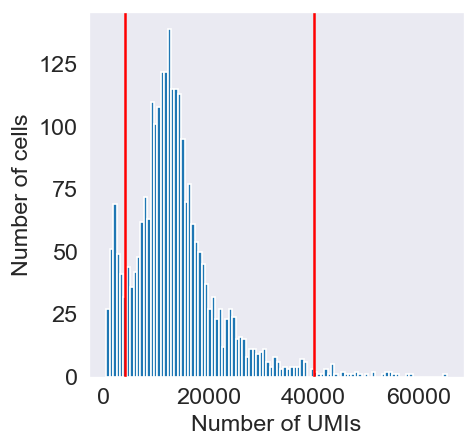

In [8]:
n, bins, *x = plt.hist(adata.obs['n_counts'], bins=100)
plt.xlabel("Number of UMIs")
plt.ylabel("Number of cells")
plt.axvline(4000, c="r")
plt.axvline(40000, c="r")
plt.show()

In [9]:
sc.pp.filter_cells(adata, min_counts=4000)
sc.pp.filter_cells(adata, max_counts=40000)

/opt/anaconda3/lib/python3.7/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


In [10]:
adata

AnnData object with n_obs × n_vars = 2286 × 20631
    obs: 'batch', 'n_counts'
    var: 'gene_ids', 'feature_types'

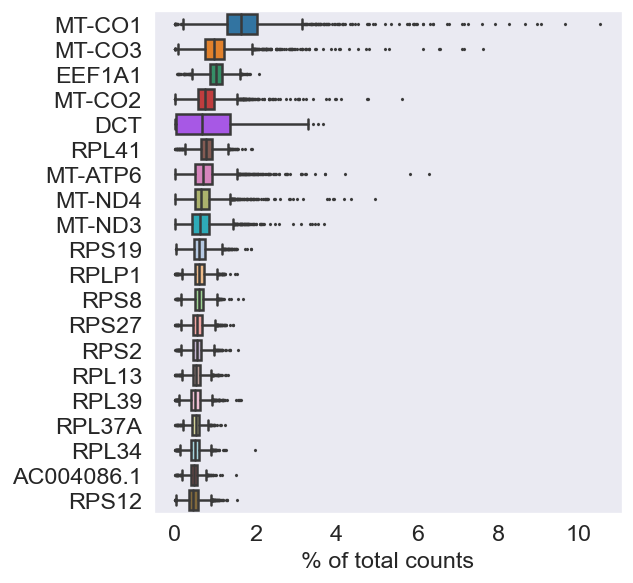

In [11]:
sc.pl.highest_expr_genes(adata, n_top=20)

In [12]:
expressed_genes = np.sum(adata.X > 0, 1)
adata.obs['n_genes'] = expressed_genes
len(expressed_genes)

2286

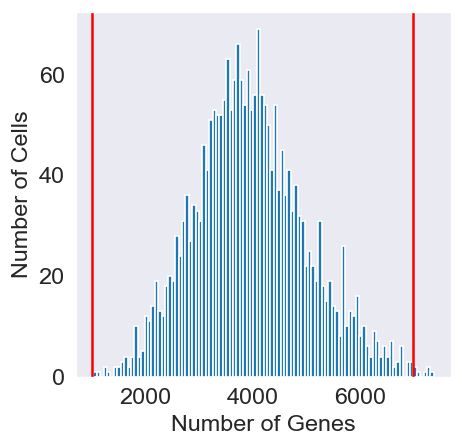

In [13]:
n, bins, *x = plt.hist(expressed_genes, bins=100)
plt.axvline(1000, c="r")
plt.axvline(7000, c="r")
plt.xlabel("Number of Genes")
plt.ylabel("Number of Cells")
plt.show()

In [14]:
adata = adata[adata.obs['n_genes'] > 1000, :].copy()
adata = adata[adata.obs['n_genes'] < 7000, :].copy()

/opt/anaconda3/lib/python3.7/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
/opt/anaconda3/lib/python3.7/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


In [15]:
mito_genes = adata.var_names.str.startswith('MT-')
adata.obs['percent_mito'] = np.sum(
    adata[:, mito_genes].X, axis=1) / np.sum(adata.X, axis=1)
adata.obs['n_counts'] = adata.X.sum(axis=1)

In [16]:
adata

AnnData object with n_obs × n_vars = 2279 × 20631
    obs: 'batch', 'n_counts', 'n_genes', 'percent_mito'
    var: 'gene_ids', 'feature_types'

... storing 'feature_types' as categorical


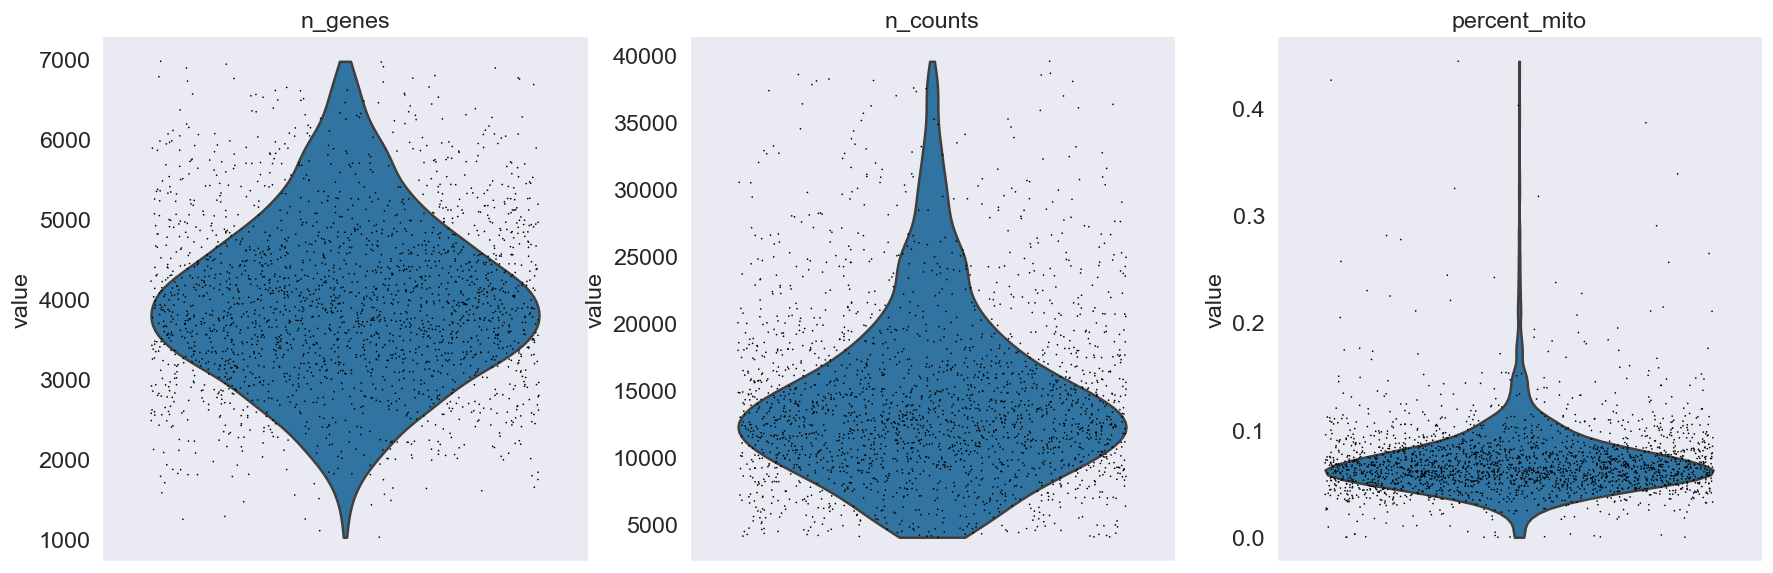

In [17]:
sc.pl.violin(adata, ['n_genes', 'n_counts', 'percent_mito'],
             jitter=0.4, multi_panel=True)

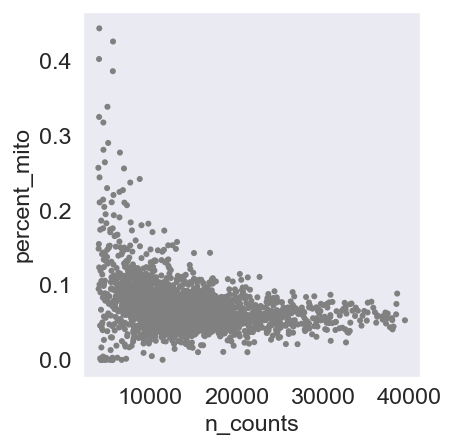

In [18]:
sc.pl.scatter(adata, x='n_counts', y='percent_mito')

In [19]:
adata = adata[adata.obs['percent_mito'] < 0.15].copy()

/opt/anaconda3/lib/python3.7/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


In [20]:
adata_raw = adata.copy()

In [21]:
adata

AnnData object with n_obs × n_vars = 2220 × 20631
    obs: 'batch', 'n_counts', 'n_genes', 'percent_mito'
    var: 'gene_ids', 'feature_types'

In [22]:
sc.pp.filter_genes(adata, min_cells=20)

In [23]:
sc.pp.normalize_total(adata)

In [24]:
adata.raw = adata

In [25]:
S_genes_hum = ["MCM5", "PCNA", "TYMS", "FEN1", "MCM2", "MCM4", "RRM1", "UNG", "GINS2", 
            "MCM6", "CDCA7", "DTL", "PRIM1", "UHRF1", "CENPU", "HELLS", "RFC2", 
            "RPA2", "NASP", "RAD51AP1", "GMNN", "WDR76", "SLBP", "CCNE2", "UBR7", 
            "POLD3", "MSH2", "ATAD2", "RAD51", "RRM2", "CDC45", "CDC6", "EXO1", "TIPIN", 
            "DSCC1", "BLM", "CASP8AP2", "USP1", "CLSPN", "POLA1", "CHAF1B", "BRIP1", "E2F8"]
G2M_genes_hum = ["HMGB2", "CDK1", "NUSAP1", "UBE2C", "BIRC5", "TPX2", "TOP2A", "NDC80",
             "CKS2", "NUF2", "CKS1B", "MKI67", "TMPO", "CENPF", "TACC3", "PIMREG", 
             "SMC4", "CCNB2", "CKAP2L", "CKAP2", "AURKB", "BUB1", "KIF11", "ANP32E", 
             "TUBB4B", "GTSE1", "KIF20B", "HJURP", "CDCA3", "JPT1", "CDC20", "TTK",
             "CDC25C", "KIF2C", "RANGAP1", "NCAPD2", "DLGAP5", "CDCA2", "CDCA8", "ECT2", 
             "KIF23", "HMMR", "AURKA", "PSRC1", "ANLN", "LBR", "CKAP5", "CENPE", 
             "CTCF", "NEK2", "G2E3", "GAS2L3", "CBX5", "CENPA"]
sc.tl.score_genes_cell_cycle(adata, s_genes=S_genes_hum, g2m_genes=G2M_genes_hum)

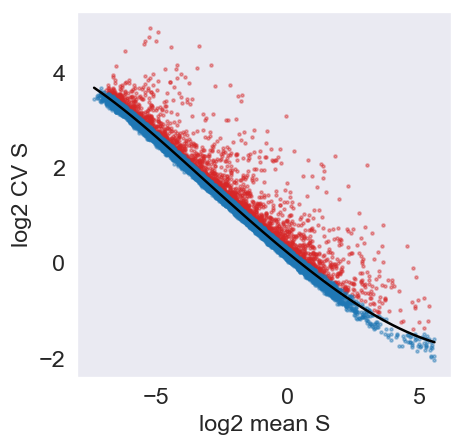

In [26]:
cv_vs_mean_keep = filter_cv_vs_mean(adata.X.toarray().T, N=2000, max_expr_avg=50)

In [27]:
sc.pp.log1p(adata)

In [28]:
adata = adata[:, cv_vs_mean_keep].copy()

/opt/anaconda3/lib/python3.7/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


In [29]:
sc.pp.regress_out(adata, ['S_score'])

... storing 'phase' as categorical


In [30]:
sc.pp.regress_out(adata, ['G2M_score'])

In [31]:
sc.pp.scale(adata, max_value=10)

In [32]:
sc.tl.pca(adata, svd_solver='arpack')

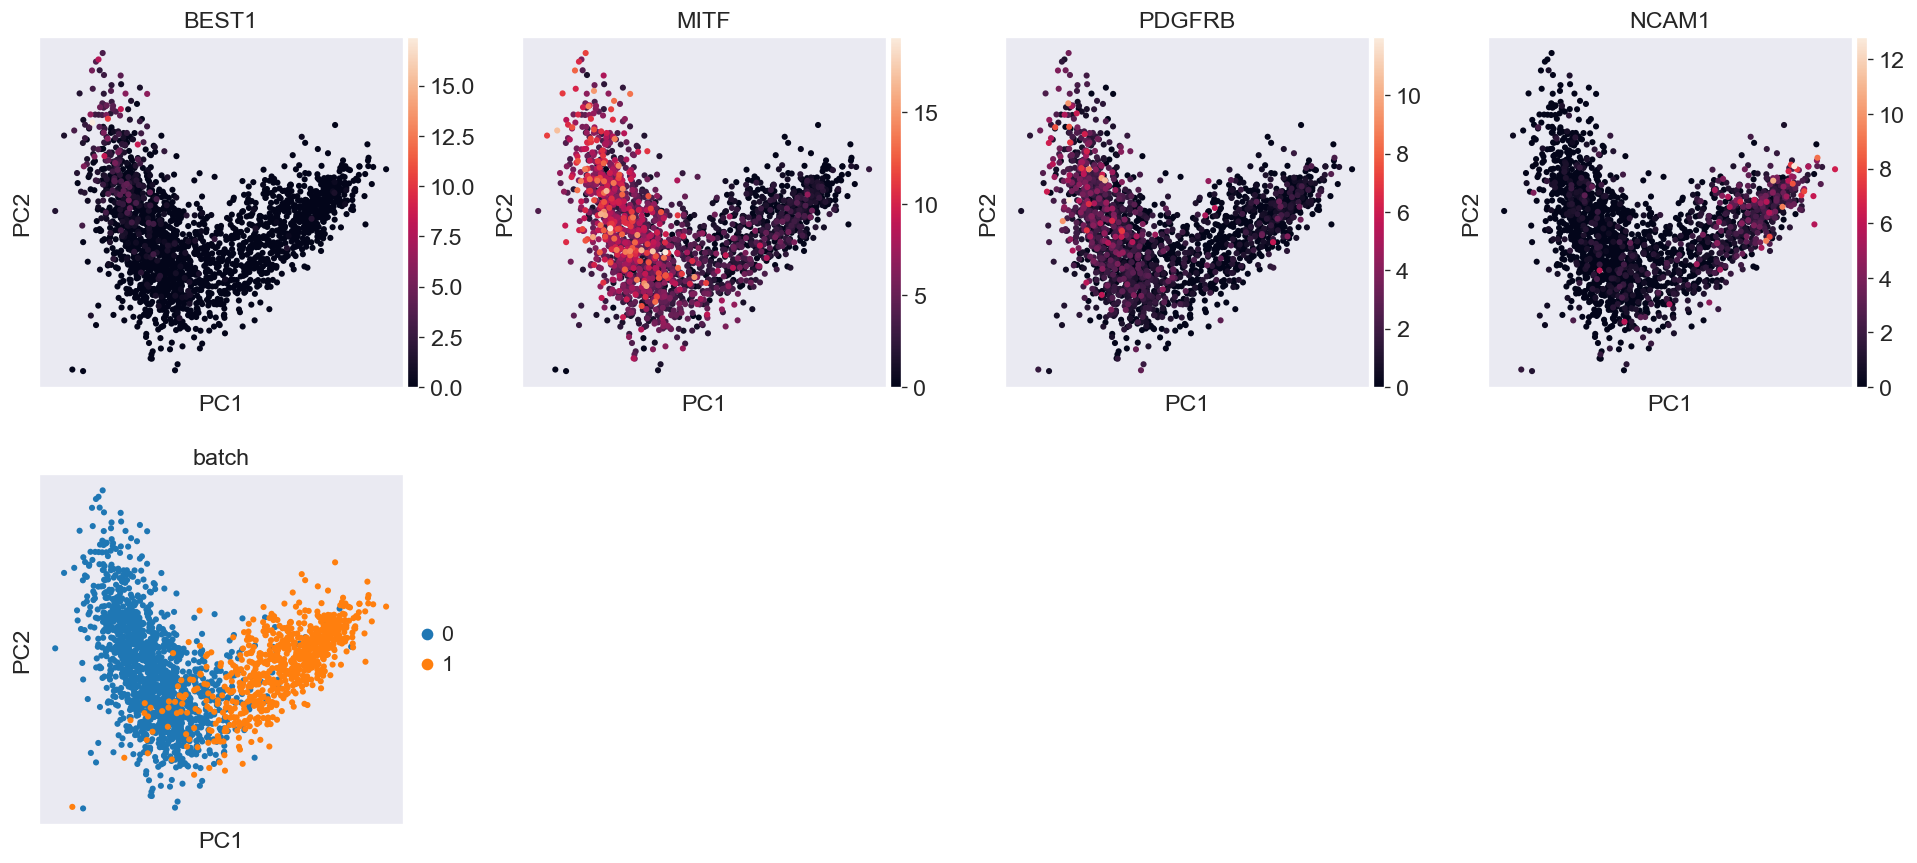

In [33]:
sc.pl.pca(adata, color=['BEST1', 'MITF', 'PDGFRB', 'NCAM1', 'batch'])

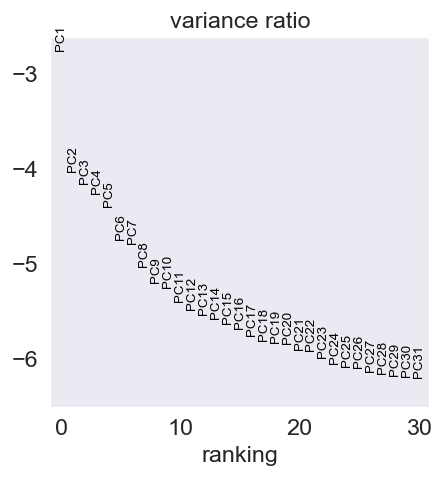

In [34]:
sc.pl.pca_variance_ratio(adata, log=True)

In [35]:
sc.pp.neighbors(adata, n_neighbors=30, n_pcs=5)

In [36]:
sc.tl.umap(adata, alpha=0.3, min_dist=0.5, random_state=0)

In [37]:
sc.tl.louvain(adata, resolution=1)

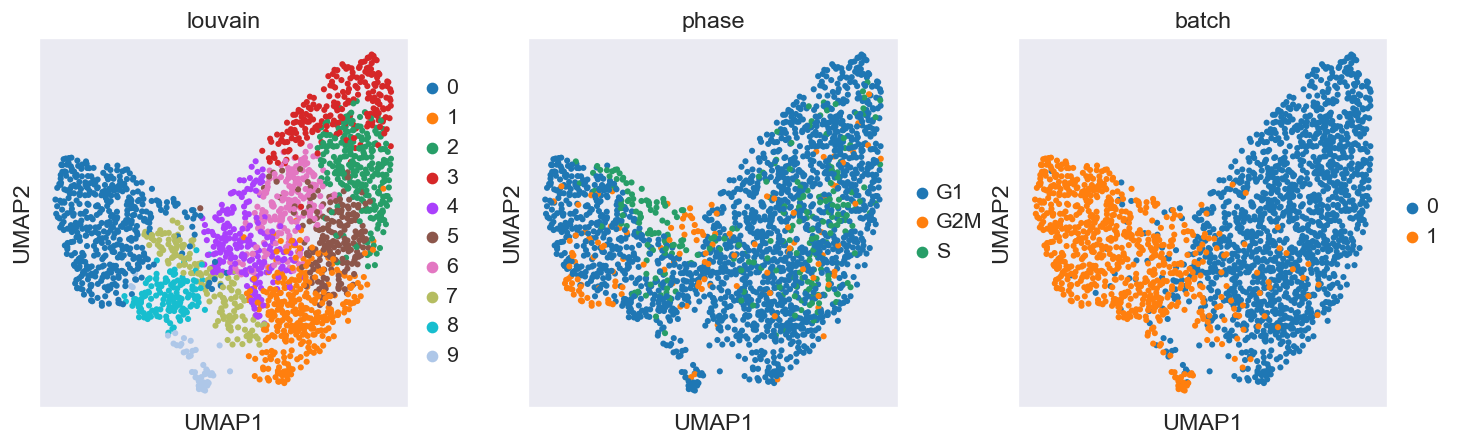

In [38]:
sc.pl.umap(adata, use_raw=True, color=['louvain', "phase", 'batch'], ncols=3)

In [39]:
adata_raw.obsm["X_umap"] = adata.obsm["X_umap"]
adata_raw.obs["louvain"] = adata.obs["louvain"]

In [40]:
adata_raw_norm = adata_raw.copy()
sc.pp.normalize_total(adata_raw_norm)
sc.pp.log1p(adata_raw_norm)

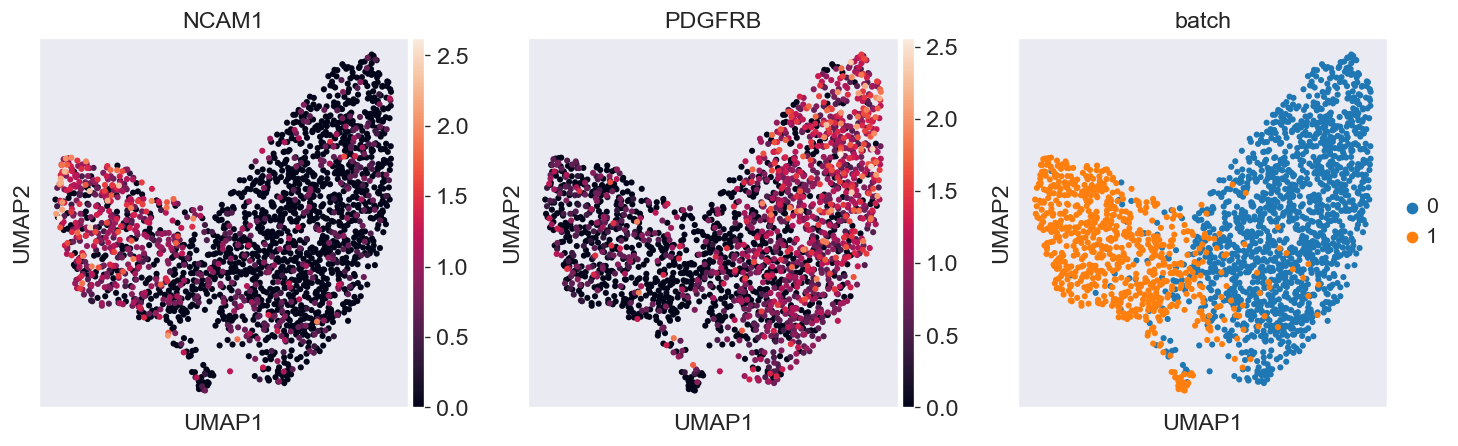

In [41]:
sc.pl.umap(adata_raw_norm, use_raw=False, color=["NCAM1", "PDGFRB", "batch"], ncols=5)

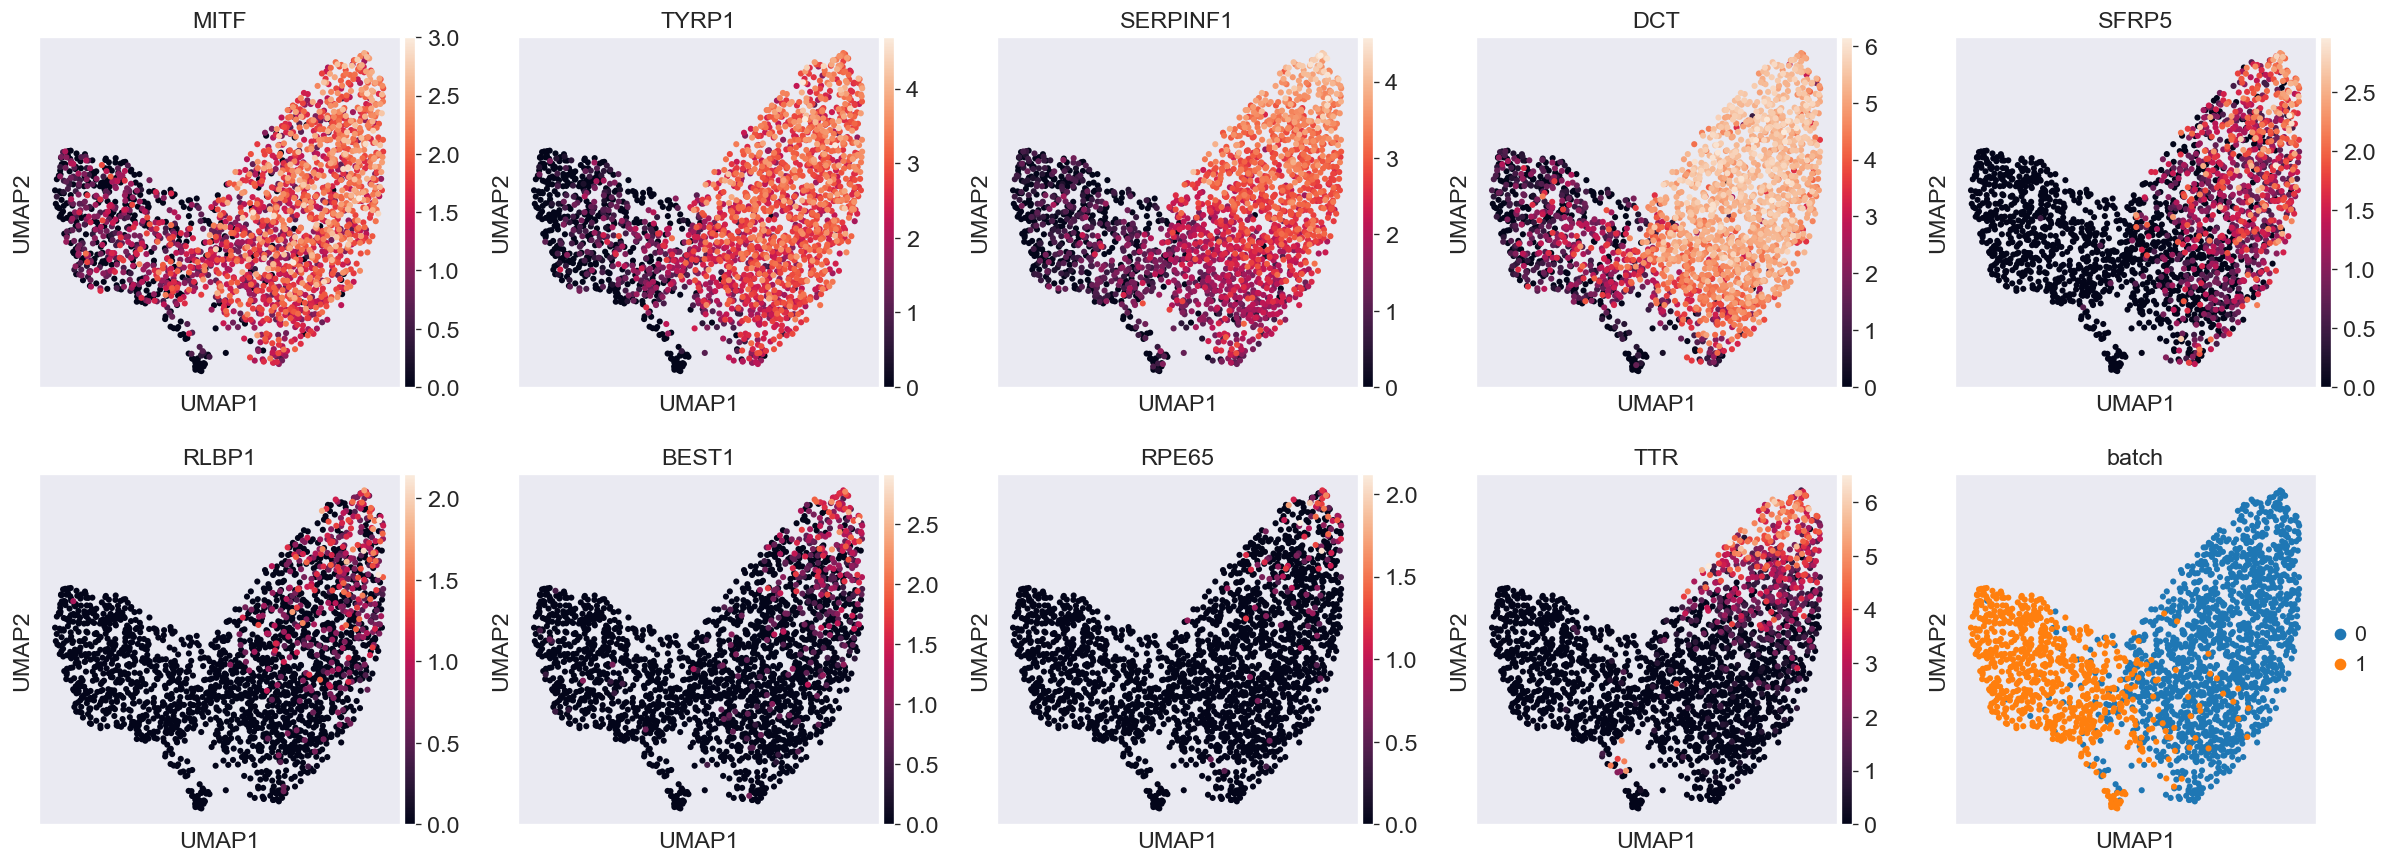

In [42]:
sc.pl.umap(adata_raw_norm, use_raw=False, color=["MITF", "TYRP1", "SERPINF1", "DCT", "SFRP5",
                                                 "RLBP1", "BEST1", "RPE65", "TTR", "batch"], ncols=5)

In [43]:
louvain2name = {'0':"RetProg", '1':"EarlyRPE", '2':"LateRPE", '3': "LateRPE", '4':"EarlyRPE",
                '5':"MidRPE", '6':"MidRPE", '7': "RetProg", '8':"RetProg", '9': "RetProg"}

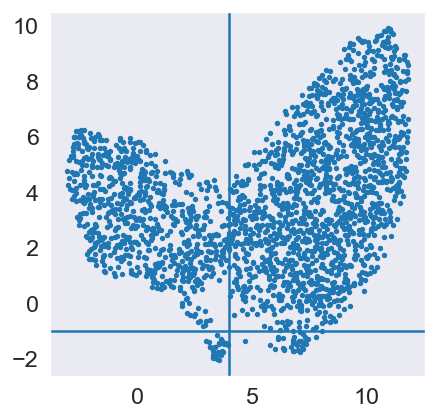

In [44]:
plt.scatter(adata.obsm["X_umap"][:, 0], adata.obsm["X_umap"][:, 1], s=5)
plt.axvline(4)
plt.axhline(-1)

In [45]:
ct = []
for i,x,y in zip(adata.obs["louvain"], adata.obsm["X_umap"][:, 0], adata.obsm["X_umap"][:, 1]):
    if i=="7" and x>4:
        ct.append("EarlyRPE")
    elif i=="7" and x<4:
        ct.append("RetProg")
    elif i=="9" and y<-1:
        ct.append("NeuralCrest")
    else:
        ct.append(louvain2name[i])

In [46]:
from collections import Counter
Counter(ct)

Counter({'LateRPE': 484,
         'RetProg': 690,
         'NeuralCrest': 29,
         'EarlyRPE': 606,
         'MidRPE': 411})

In [47]:
adata.obs["cell_type"] = ct

... storing 'cell_type' as categorical


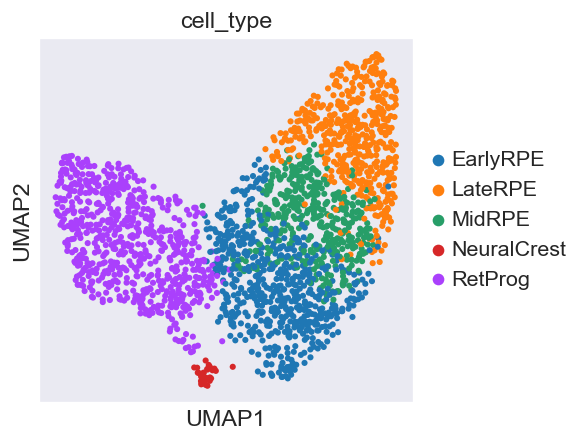

In [48]:
sc.pl.umap(adata, color=["cell_type"])

In [49]:
adata_raw_norm.obs["cell_type"] = adata.obs["cell_type"]

In [50]:
n2n = {'EarlyRPE':0, 'LateRPE':2, 'MidRPE':1, 'NeuralCrest':3, 'RetProg':4}

In [51]:
from miscalg import enrichment
Xgen = adata_raw_norm.X.toarray().T
enrichment_score = enrichment.enrichment_score(Xgen, np.array([n2n[i] for i in adata_raw_norm.obs["cell_type"]]))
emarkers = enrichment.extract_enriched(enrichment_score, 
                                      np.array(adata_raw_norm.var.index), n_enriched=10)
edf = pd.DataFrame(emarkers)
edf.head(15)

,0,1,2,3,4
0,KMO,TFPI2,TTR,DLX5,PTH2
1,OTOGL,CNTNAP5,SLC6A13,CLDN7,BHLHE22
2,ACTC1,CHRNA3,BEST1,AGR2,FEZF2
3,LYPD1,GNG11,SMOC2,SPRR3,DLK1
4,NPY,GNGT1,CSF1R,ELF5,CRB1
5,CADPS,ADAM28,SLC6A20,S100A14,PTPRO
6,EDN2,SPON2,BCO1,RAB25,SOX2
7,ANKRD1,SNCB,ERMN,DLX6,SPP1
8,TAGLN,TGFBI,RPE65,SIX1,PCDH11X
9,CYTIP,PRPH,ADTRP,TACSTD2,VSX2


In [52]:
b2n = {"0":"D30:CD140b-High", "1":"D30:NCAM1-High"}
adata_raw_norm.obs["batch"] = [b2n[i] for i in adata_raw_norm.obs["batch"]]

adata_raw_norm1 = adata_raw_norm[adata_raw_norm.obs["batch"]=="D30:NCAM1-High"]
adata_raw_norm2 = adata_raw_norm[adata_raw_norm.obs["batch"]=="D30:CD140b-High"]

/opt/anaconda3/lib/python3.7/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


In [53]:
adata_raw_norm1.obs["cell_type"].value_counts()/len(adata_raw_norm1)*100

RetProg        86.239782
EarlyRPE        9.809264
NeuralCrest     2.997275
MidRPE          0.953678
Name: cell_type, dtype: float64

In [54]:
adata_raw_norm2.obs["cell_type"].value_counts()/len(adata_raw_norm2)*100

EarlyRPE       35.935397
LateRPE        32.570659
MidRPE         27.187079
RetProg         3.835801
NeuralCrest     0.471063
Name: cell_type, dtype: float64

In [55]:
adata_raw_norm

AnnData object with n_obs × n_vars = 2220 × 20631
    obs: 'batch', 'n_counts', 'n_genes', 'percent_mito', 'louvain', 'cell_type'
    var: 'gene_ids', 'feature_types'
    uns: 'log1p', 'batch_colors'
    obsm: 'X_umap'